In [22]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill, create_mask

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)

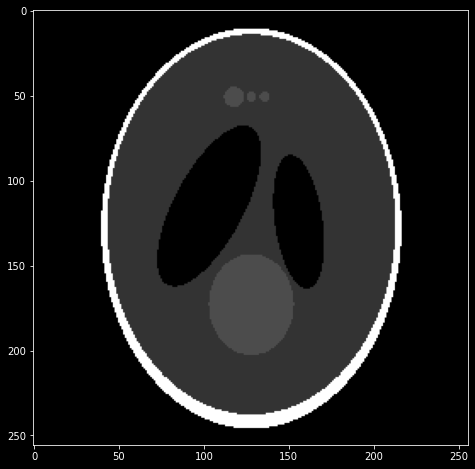

In [2]:
phantom = sigpy.shepp_logan((256, 256))
rows, cols = phantom.shape
_ = plt.imshow(np.abs(phantom), cmap="gray")

0.0791168212890625

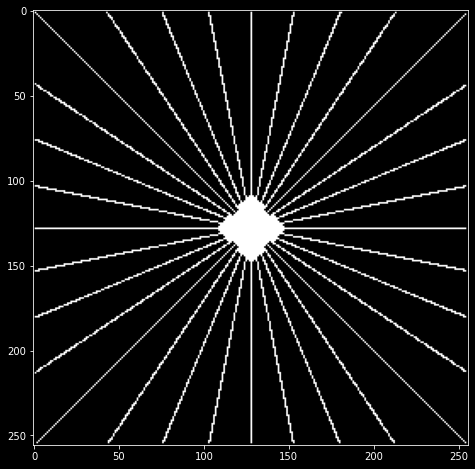

In [3]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 32, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]
b = np.fft.fft2(phantom).flatten()[samples_rows]

get_proportion(phantom.flatten(), b)
_ = plt.imshow(np.fft.fftshift(radial_mask))

PSNR: 19.922996530904836
SSIM: 0.30438127746616445
SNR: 6.590090835878178
MSE: 0.013424024462264846


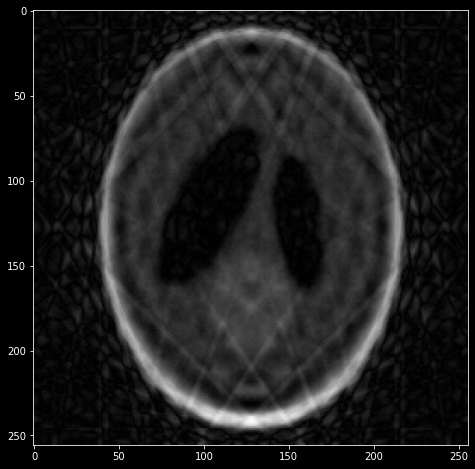

In [4]:
zero_filled = zero_fill(b, samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = calculate_metrics(np.abs(phantom), np.abs(zero_filled))

# No prior information LP minimization

In [5]:
filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 22.79390859603882s


PSNR: 31.776908452666895
SSIM: 0.8234194401565108
SNR: 18.147671968258766
MSE: 0.0009378310807819102


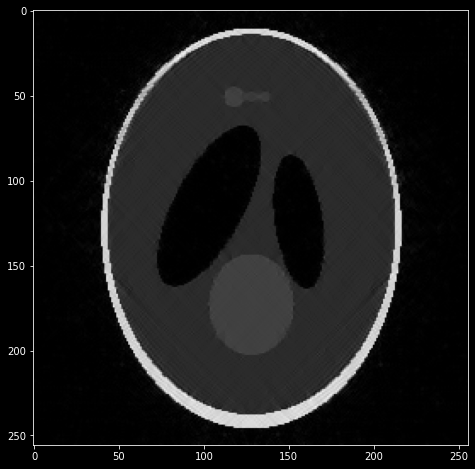

In [6]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

nopi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(nopi_recon))

# Visualizing prior information leveraged

<module 'mri_cs' from '../../../src/mri_cs.py'>

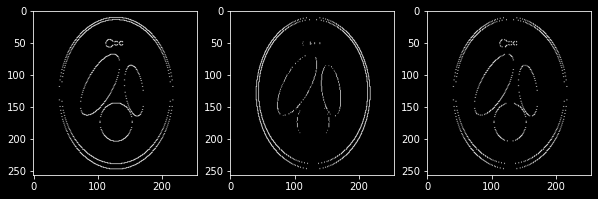

In [11]:
reload(mri_cs)
phi = mri_cs.prior_information(np.abs(phantom), pi_prop=10/100, filters=filters)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
_ = ax1.imshow(create_mask(phi[0]))
_ = ax2.imshow(create_mask(phi[1]))
_ = ax3.imshow(create_mask(phi[2]))

In [19]:
phi[0]

array([62575, 61282, 61089, ..., 14450, 14452, 41577])

In [12]:
import gaussian_2d_domain
cov_matrix = np.array([[10, 0], [0, 10]])
reload(gaussian_2d_domain)

weights, I, J = gaussian_2d_domain.weights_from_prior(
    phi, rows, cols, taufactor=1e6, taumin=1, cov_matrix=cov_matrix)

<module 'gaussian_2d_domain' from '../../../src/gaussian_2d_domain.py'>

<module 'gaussian_2d_domain' from '../../../src/gaussian_2d_domain.py'>

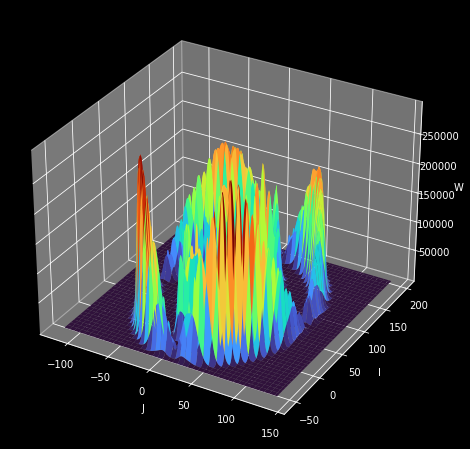

In [23]:
reload(gaussian_2d_domain)
gaussian_2d_domain.visualize3d(weights, J, I, frame=2)

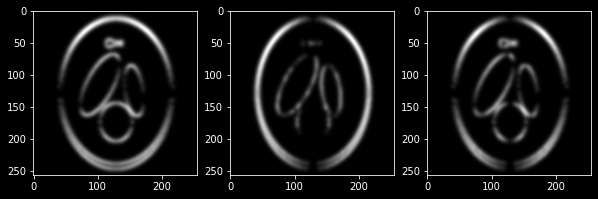

In [14]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    _ = ax[i].imshow(weights[..., i])

# LP Minimization with pre filtering and prior information

In [16]:
weights[..., 1].flatten().shape

(65536,)

<module 'gaussian_mri_cs' from '../../../src/gaussian_mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 61.72546076774597s
PSNR: 38.07400472661626
SSIM: 0.9697153818491608
SNR: 24.378888635567403
MSE: 0.00022335874200087226


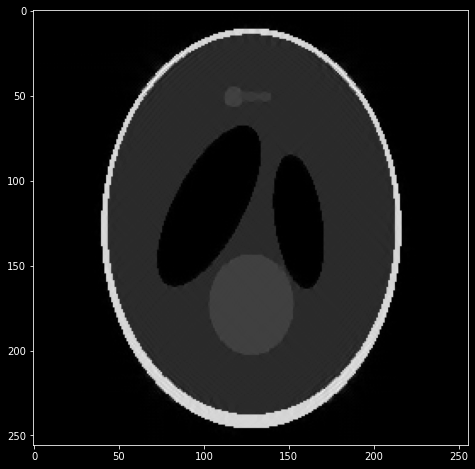

In [56]:
import gaussian_mri_cs
reload(gaussian_mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1


pi_recon = gaussian_mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                        p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                        maxiterperstage=maxiterperstage,
                                        phi=phi, gaussian_weights=weights, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(pi_recon))